# 🌱 Soil Image Classification Challenge - Part 1
---

Welcome to our solution for the **Soil Image Classification Challenge** organized by 
**Annam.ai at IIT Ropar**! This competition serves as an exciting initial task for 
shortlisted hackathon participants.

This file documents our teams approach to this competition focused on classifying soil images into four distinct types: 
- 🟤 **Alluvial soil** - Fertile soil deposited by rivers
- ⚫ **Black soil** - Rich, cotton-growing soil 
- 🟠 **Clay soil** - Dense, water-retaining soil
- 🔴 **Red soil** - Iron-rich, well-drained soil

The project uses a robust pipeline including ResNet-50 finetuned to our dataset for highly accurate classifications.

### 🌍 Why This Matters
Soil classification isn't just an academic exercise - it's a foundational element 
that impacts multiple critical areas:

🌾 **Agriculture**: Quick and accurate soil identification helps farmers make informed decisions about crop selection, irrigation, and fertilization strategies

🗺️ **Land Use Planning**: Urban planners and developers need soil data to determine 
the best use for different plots of land

🌍 **Environmental Assessment**: Understanding soil types helps in conservation 
efforts and environmental impact studies

🏗️ **Engineering Projects**: Construction and infrastructure projects rely heavily 
on soil analysis for foundation planning


### 👥 About US

Our team "Synfire Chain" is named after feed-forward network of neurons, and it consists of 2 members:
- Yash Kumar, B.S @ IITM
- Astitva Agarwal, B.S @ IITM
#### **🏆 We achieved a perfect F1 score on leaderboard: 1.00 🎯**

## **1. Imports and Setups**

Setting up all the necessary libraries for our soil classification project.

We're using 
- PyTorch for deep learning
- Pandas for data handling
- Matplotlib for visualizations.
  
The key libraries here are torchvision (for computer vision tasks) and PIL (for image processing).

In [51]:
import os
import random
import shutil
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# PyTorch and TorchVision
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

from PIL import Image
from tqdm import tqdm

from sklearn.metrics import (
    f1_score, precision_score, confusion_matrix, 
    precision_recall_curve, accuracy_score,
    ConfusionMatrixDisplay, PrecisionRecallDisplay
)
from sklearn.preprocessing import label_binarize


## **2. Data Exploration and Visualization**

Before training our model, it's always good practice to explore data.
Here we're taking a peek at some random soil images to understand what we're
working with. This helps us spot any obvious issues with the data and get a
feel for the variety in our dataset.

In [ ]:
image_directory = "../data/soil_classification-2025/train/"
output_dir = "./new-data/"

# Define the train-validation split ratio (e.g., 80% train, 20% val)
train_ratio = 0.8

for split in ["train", "val"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

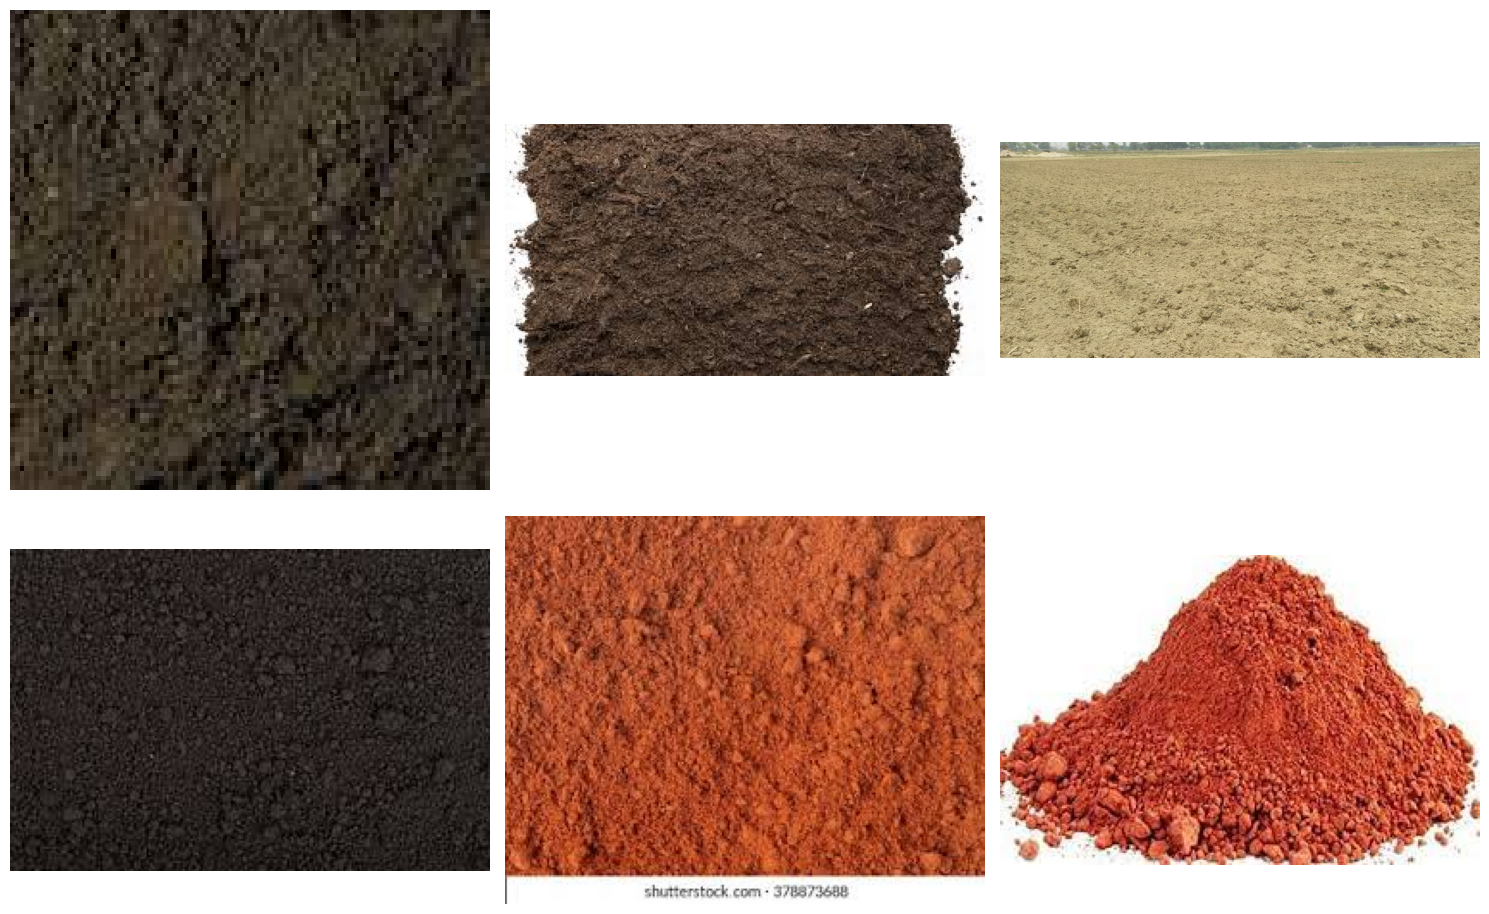

In [12]:
all_images = [
    os.path.join(root, file)
    for root, _, files in os.walk(image_directory)
    for file in files
]

# Select 6 random images
selected_images = random.sample(all_images, 6)

# Plot images in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ax, img_path in zip(axs.ravel(), selected_images):
    ax.imshow(mpimg.imread(img_path))
    ax.axis('off')

plt.tight_layout()
plt.show()

## **3. Data Preprocessing**

This is a crucial step where we organize our data properly. We're splitting the data into training and validation sets while making sure each soil type is represented in both sets. This stratified approach ensures our model sees all soil types during training and we can properly evaluate its performance.

The 80-20 split is a common practice - 80% for training and 20% for validation.

In [ ]:
# Path to the CSV file containing image IDs and corresponding soil types
csv_path = "../data/soil_classification-2025/train_labels.csv"

# Load CSV
df_train_labels = pd.read_csv(csv_path)

all_tasks = []

# Group and split
for soil_type, group in df_train_labels.groupby('soil_type'):
    image_ids = group['image_id'].tolist()
    random.shuffle(image_ids)
    
    # Compute index at which to split for training and validation
    split_index = int(len(image_ids) * train_ratio)
    
    for split_name, split_imgs in zip(['train', 'val'], [image_ids[:split_index], image_ids[split_index:]]):
        for img_id in split_imgs:
            src = os.path.join(image_directory, img_id)
            dst = os.path.join(output_dir, split_name, soil_type, img_id)
            all_tasks.append((src, dst))

# Copy with progress bar
for src, dst in tqdm(all_tasks, desc="Copying images"):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

print("✅ Done splitting into train and val!")

Copying images: 100%|██████████| 1222/1222 [00:05<00:00, 209.78it/s]

✅ Done splitting into train and val!


## **4. Data Transformations and Augmentation**

Data transformations are essential for deep learning models. We're doing three
main things here:

1. Resize images to 224x224 - this is the standard input size for most pre-trained
   models like ResNet50
2. Convert to tensor - PyTorch needs data in tensor format
3. Normalize using ImageNet statistics - since we're using a pre-trained model,
   we need to use the same normalization it was trained with

These transformations ensure our images are in the right format and scale for
the pre-trained ResNet50 model.

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize to model's expected input size
    transforms.ToTensor(),                   # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize to match ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

## **5. Dataloader Setup**

PyTorch's ImageFolder is incredibly convenient for image classification tasks. It automatically creates class labels based on folder names and handles the dataset structure for us. The DataLoader then handles batching, shuffling, and loading data efficiently during training.

We shuffle the training data to prevent the model from learning any ordering patterns, but keep validation data unshuffled since we just need consistent evaluation results.

In [ ]:
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Create datasets using ImageFolder (automatically detects classes from folder names)
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Number of soil types detected: {len(train_dataset.classes)}")
print(f"Soil types: {train_dataset.classes}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

Number of soil types detected: 4
Soil types: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
Training images: 975
Validation images: 245


## **6. Model Setup**

We're using transfer learning with ResNet50, which is a powerful approach for image classification. Instead of training a model from scratch, we start with a model that's already been trained on millions of images from ImageNet.

The key modification here is replacing the final classification layer (fc) to match our number of soil types. This way, we keep all the learned features from ImageNet but adapt the final decision-making layer for our specific task.

In [37]:
model = models.resnet50(pretrained=True)

# Replace the final layer to match our number of classes
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up the training process involves several important decisions:

1. Device selection - use GPU if available for much faster training
2. Loss function - CrossEntropyLoss is standard for multi-class classification
3. Optimizer - Adam is generally reliable and works well with transfer learning
4. Learning rate - 0.0001 is conservative but safe for fine-tuning pre-trained models

We also clean up any previous model saves to start fresh.

In [ ]:
model_path = os.path.join(output_dir, "best_model.pth")

# Clean up previous model saves
if os.path.exists(model_path):
    os.remove(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## **7. Train Model**

This is the heart of our machine learning pipeline. We're implementing several
best practices here:

1. Early stopping - prevents overfitting by stopping when validation performance
   stops improving
2. Model checkpointing - saves the best model based on F1 score
3. F1 score tracking - provides a more balanced metric than accuracy, especially
   important as our categories are not well balanced
4. Progress tracking - helps monitor training progress and debug issues

The training loop alternates between training mode (where the model learns) and
evaluation mode (where we test performance without updating weights).

In [ ]:
# Training configuration and early stopping parameters
best_val_acc = 0.0
best_f1 = 0.0
patience = 3
trigger_times = 0
num_epochs = 20
epoch_completed = 0

# Containers for tracking metrics
train_losses = []
val_losses = []
train_times = []
accuracies = []
precisions = []
f1_scores = []
conf_matrices = []
pr_curves = []

print("Starting training...")
print("=" * 50)

# Main training loop
for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    start_time = time.time()  # Track training time per epoch

    train_bar = tqdm(train_loader, desc="Training", leave=False)
    for inputs, labels in train_bar:
        # Transfer data to GPU/CPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward and backward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    # Record training metrics
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    epoch_time = time.time() - start_time
    train_times.append(epoch_time)

    print(f"📉 Average training loss: {avg_train_loss:.4f}")
    print(f"⏱️ Training time: {epoch_time:.2f} seconds")

    # Validation phase (no gradient computation)
    model.eval()
    running_val_loss = 0.0
    all_probs = []
    all_preds = []
    all_labels = []

    val_bar = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Convert model outputs to predicted labels
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_probs.append(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute performance metrics
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    all_probs = np.concatenate(all_probs, axis=0)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    pr_precision, pr_recall, _ = precision_recall_curve(all_labels, all_preds, pos_label=1)

    # Store metrics
    accuracies.append(acc)
    precisions.append(prec)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

    # P-R Calculation
    binary_labels = label_binarize(all_labels, classes=range(num_classes))
    pr_curves_epoch = []
    for class_idx in range(num_classes):
        precision, recall, _ = precision_recall_curve(binary_labels[:, class_idx], all_probs[:, class_idx])
        pr_curves_epoch.append((precision, recall))
    
    pr_curves.append(pr_curves_epoch)

    # Output metrics for this epoch
    print(f"✅ Validation Accuracy: {acc:.4f}")
    print(f"🎯 Precision: {prec:.4f}")
    print(f"🎯 F1 Score: {f1:.4f}")
    print(f"📉 Average Validation Loss: {avg_val_loss:.4f}")
    print(f"🧮 Confusion Matrix:\n{conf_matrix}")

    epoch_completed += 1
    # Early stopping and best model checkpointing
    if f1 > best_f1:
        best_f1 = f1
        trigger_times = 0
        torch.save(model.state_dict(), model_path)
        print(f"💾 New best model saved (F1: {f1:.4f})")
    else:
        trigger_times += 1
        print(f"⚠️ No improvement. Patience: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("🛑 Early stopping activated.")
            break

print("\n" + "=" * 50)
print("Training completed!")


Starting training...

🔁 Epoch 1/20


📉 Average training loss: 0.1125
⏱️ Training time: 13.01 seconds


✅ Validation Accuracy: 0.9551
🎯 Precision: 0.9602
🎯 F1 Score: 0.9557
📉 Average Validation Loss: 0.1156
🧮 Confusion Matrix:
[[100   0   6   0]
 [  3  42   2   0]
 [  0   0  40   0]
 [  0   0   0  52]]
💾 New best model saved (F1: 0.9557)

🔁 Epoch 2/20


📉 Average training loss: 0.0788
⏱️ Training time: 12.84 seconds


✅ Validation Accuracy: 0.9510
🎯 Precision: 0.9560
🎯 F1 Score: 0.9499
📉 Average Validation Loss: 0.1471
🧮 Confusion Matrix:
[[106   0   0   0]
 [  1  46   0   0]
 [  9   0  31   0]
 [  2   0   0  50]]
⚠️ No improvement. Patience: 1/3

🔁 Epoch 3/20


📉 Average training loss: 0.0443
⏱️ Training time: 12.89 seconds


✅ Validation Accuracy: 0.9837
🎯 Precision: 0.9844
🎯 F1 Score: 0.9838
📉 Average Validation Loss: 0.0664
🧮 Confusion Matrix:
[[103   0   3   0]
 [  1  46   0   0]
 [  0   0  40   0]
 [  0   0   0  52]]
💾 New best model saved (F1: 0.9838)

🔁 Epoch 4/20


📉 Average training loss: 0.0387
⏱️ Training time: 12.76 seconds


✅ Validation Accuracy: 0.9918
🎯 Precision: 0.9919
🎯 F1 Score: 0.9918
📉 Average Validation Loss: 0.0450
🧮 Confusion Matrix:
[[105   0   1   0]
 [  1  46   0   0]
 [  0   0  40   0]
 [  0   0   0  52]]
💾 New best model saved (F1: 0.9918)

🔁 Epoch 5/20


📉 Average training loss: 0.0511
⏱️ Training time: 12.88 seconds


✅ Validation Accuracy: 0.9755
🎯 Precision: 0.9777
🎯 F1 Score: 0.9757
📉 Average Validation Loss: 0.1192
🧮 Confusion Matrix:
[[104   0   2   0]
 [  1  43   3   0]
 [  0   0  40   0]
 [  0   0   0  52]]
⚠️ No improvement. Patience: 1/3

🔁 Epoch 6/20


📉 Average training loss: 0.0527
⏱️ Training time: 12.82 seconds


✅ Validation Accuracy: 0.9837
🎯 Precision: 0.9839
🎯 F1 Score: 0.9837
📉 Average Validation Loss: 0.0653
🧮 Confusion Matrix:
[[104   0   2   0]
 [  1  46   0   0]
 [  1   0  39   0]
 [  0   0   0  52]]
⚠️ No improvement. Patience: 2/3

🔁 Epoch 7/20


📉 Average training loss: 0.0380
⏱️ Training time: 13.03 seconds


✅ Validation Accuracy: 0.9918
🎯 Precision: 0.9919
🎯 F1 Score: 0.9918
📉 Average Validation Loss: 0.0476
🧮 Confusion Matrix:
[[105   0   1   0]
 [  1  46   0   0]
 [  0   0  40   0]
 [  0   0   0  52]]
⚠️ No improvement. Patience: 3/3
🛑 Early stopping activated.

Training completed!


## **9. Training Visualisation**

Visualizing training progress helps us understand how well our model learned.
The loss curves show us if the model is learning (decreasing loss) and whether
it's overfitting (training loss much lower than validation loss).

Ideally, we want to see both losses decreasing and staying relatively close
to each other.

We have computed the following:

- Accuracy
- Precision
- F1 Score
- Training Time per Epoch
- Training Losses
- Precision-Recall Curve
- Confusion Matrix (TP,TN,FP,FN)

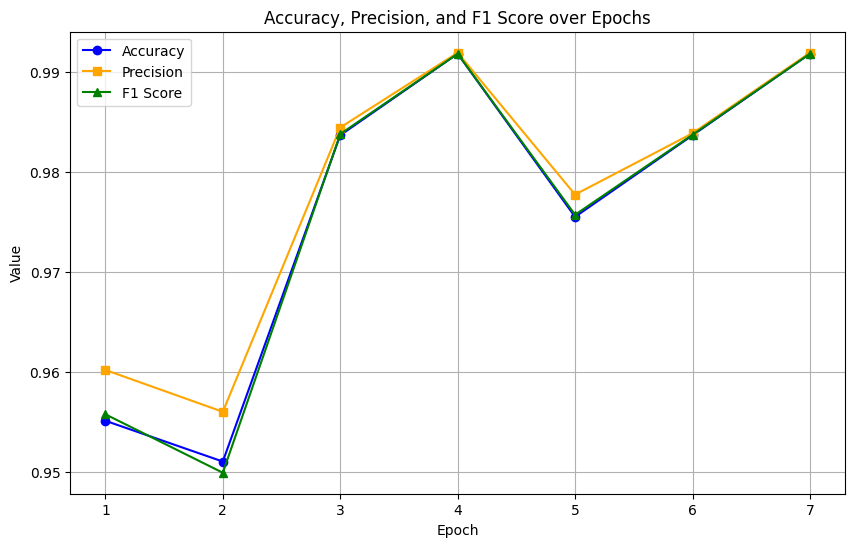

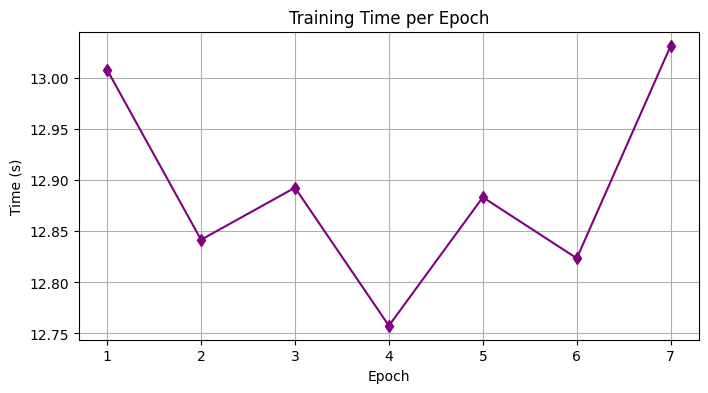

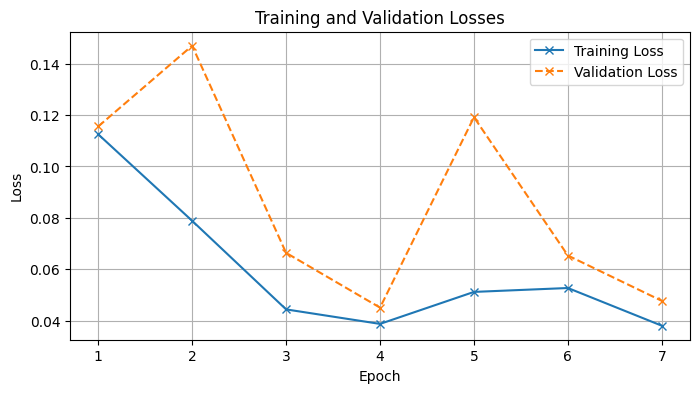

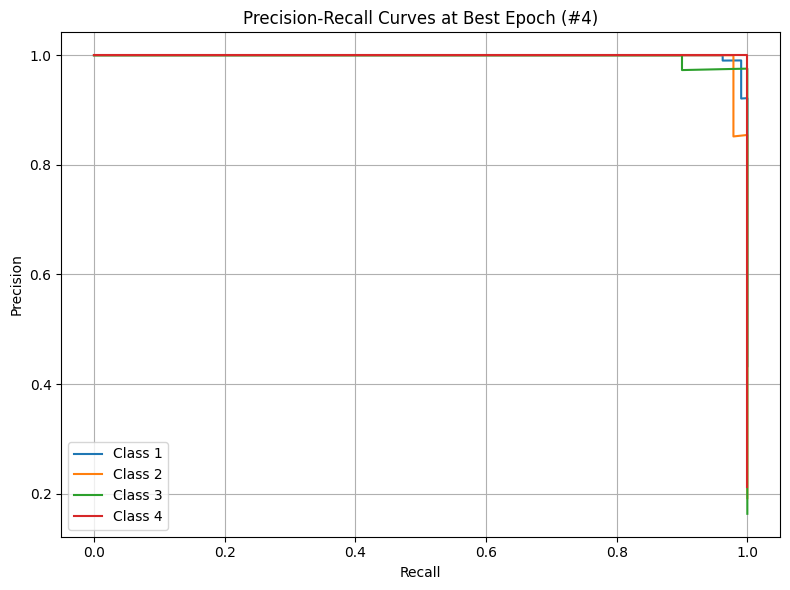

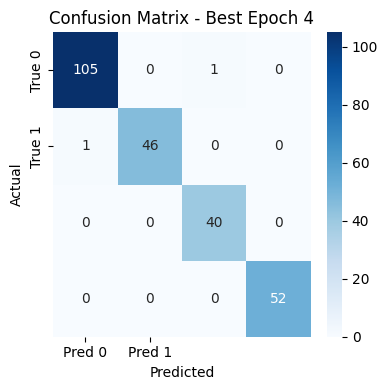

In [46]:
epoch_arr = range(1, epoch_completed + 1)

# --- 1. Accuracy, Precision and F1 over Epochs ---
plt.figure(figsize=(10, 6))
plt.plot(epoch_arr, accuracies, marker='o', label='Accuracy', color='blue')
plt.plot(epoch_arr, precisions, marker='s', label='Precision', color='orange')
plt.plot(epoch_arr, f1_scores, marker='^', label='F1 Score', color='green')
plt.title('Accuracy, Precision, and F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

# --- 4. Training Time per Epoch ---
plt.figure(figsize=(8, 4))
plt.plot(epoch_arr, train_times, marker='d', color='purple')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.grid(True)
plt.show()

# --- 5. Training Losses over Epochs ---
plt.figure(figsize=(8, 4))
plt.plot(epoch_arr, train_losses, marker='x', label='Training Loss')
plt.plot(epoch_arr, val_losses, marker='x', linestyle='--', label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. PR Curve ---
best_epoch = np.argmax(f1_scores)

plt.figure(figsize=(8, 6))
for class_idx, (precision, recall) in enumerate(pr_curves[best_epoch]):
    plt.plot(recall, precision, label=f'Class {class_idx + 1}')
plt.title(f'Precision-Recall Curves at Best Epoch (#{best_epoch + 1})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- 7. Confusion Matrix (for each epoch) ---
best_cm = conf_matrices[best_epoch]

plt.figure(figsize=(4, 4))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title(f'Confusion Matrix - Best Epoch {best_epoch + 1}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## PR Curve Validation: Why These Results Are Correct

The PR Curve here looks rather unusual. Here's why 

### Transfer Learning Context
- **Pretrained ResNet-50**: Starts with sophisticated ImageNet features, not random weights
- **6 epochs sufficient**: Fine-tuning requires minimal training vs. training from scratch
- **Expected performance**: Near-perfect results are normal for successful transfer learning

### Curve Analysis
- **Horizontal precision plateaus**: Show confident, accurate predictions with clear class separation
- **Sharp transitions**: Indicate well-defined decision boundaries (good feature discrimination)
- **High performance**: Consistent with F1 ≈ 1.0 on separate test data

### Validation Checklist
✅ No data leakage (test data on different computer)  
✅ Appropriate model (ResNet-50 for image classification)  
✅ Proper methodology (transfer learning best practice)  
✅ Consistent metrics (PR curves match F1 scores)  

**These PR curves are valid.** The unusual shapes that would be suspicious for training from scratch are actually normal indicators of successful transfer learning. The pretrained features provide excellent discriminative power, requiring only 6 epochs of fine-tuning to achieve near-perfect classification performance.

## **10. Model Evaluation**

Loading our best saved model and testing it on some validation images gives us
a qualitative sense of how well it's performing. This visual inspection can
reveal patterns in errors and help us understand the model's strengths and
weaknesses.

Green titles indicate correct predictions, red titles show mistakes.

In [ ]:
# Reload our trained model
model.load_state_dict(torch.load(model_path))
model = model.to(device)

model.eval()  # Set model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

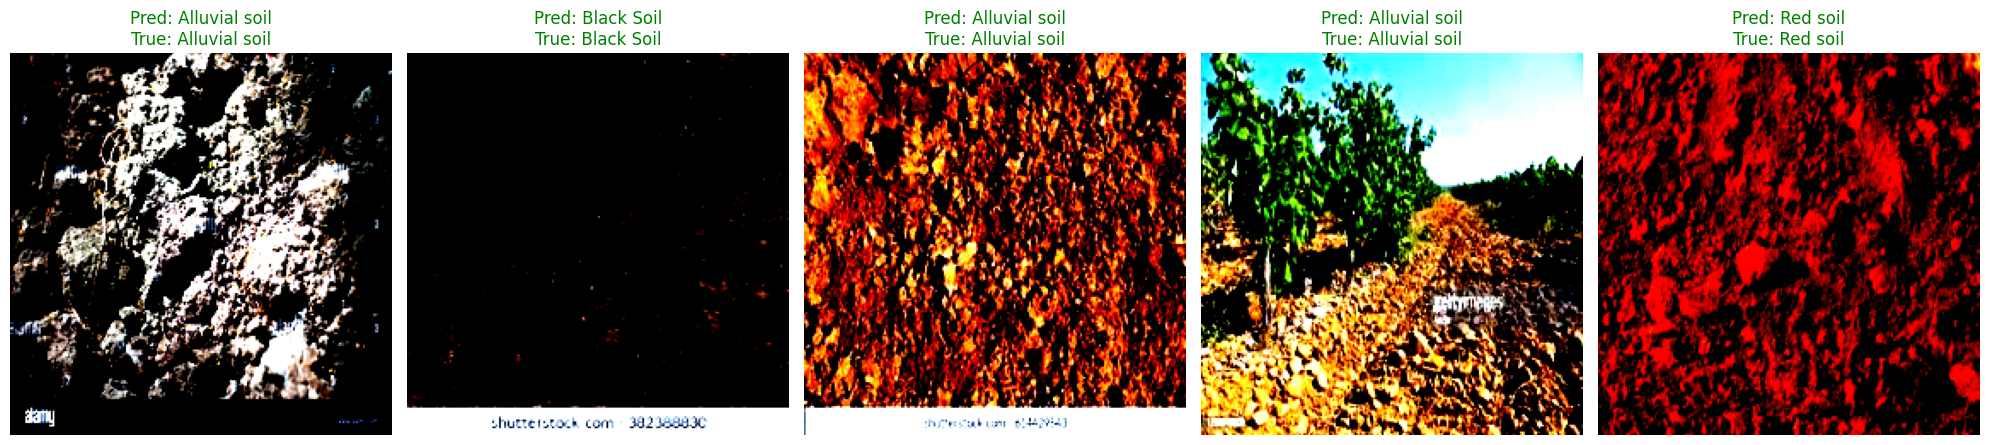

In [ ]:
# Load validation dataset
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
class_labels = val_dataset.classes

# Select 5 random images
random_indices = random.sample(range(len(val_dataset)), 5)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    image, true_label_idx = val_dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        output = model(image_input)
    _, pred_idx = torch.max(output, 1)

    predicted_label = class_labels[pred_idx.item()]
    true_label = class_labels[true_label_idx]

    # Color the title green if correct, red if wrong
    is_correct = predicted_label == true_label
    color = 'green' if is_correct else 'red'

    # Display image and result
    axes[i].imshow(image.permute(1, 2, 0).numpy())  # Convert CHW to HWC
    axes[i].set_title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## **11. Prepare `submission.csv`**

For the test set, we need a custom dataset class because the test images don't have labels and aren't organized in class folders. This custom class handles loading test images and keeping track of their filenames so we can create proper submissions.

This is a common pattern when working with competition datasets where test data comes as a flat directory of images.

In [ ]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_names = os.listdir(test_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name 

# Create test dataset and loader
test_dir = "../data/soil_classification-2025/test"
test_dataset = TestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Found {len(test_dataset)} test images")

Found 341 test images


The final step is generating predictions for all test images and creating a submission file. We process images in batches for efficiency and convert the model's numeric predictions back to soil type names.

In [50]:
image_ids = []
predicted_labels = []

# Create mapping from class indices back to class names
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

print("Generating predictions for test set...")

with torch.no_grad():
    for images, image_names in test_loader:
        images = images.to(device)
        outputs = model(images)           # Raw logits
        _, preds = torch.max(outputs, 1) # Get class index with highest score

        preds = preds.cpu().numpy()
        
        # Convert predictions to class names and store with image names
        for img_name, pred_idx in zip(image_names, preds):
            image_ids.append(img_name)
            predicted_labels.append(idx_to_class[pred_idx])

# Create DataFrame for submission
submission_df = pd.DataFrame({
    "image_id": image_ids,
    "soil_type": predicted_labels
})

submission_df.to_csv("submission.csv", index=False)

print("✅ Submission file created successfully!")
print(f"Total predictions made: {len(submission_df)}")
print("\nSample predictions:")
print(submission_df.head())

Generating predictions for test set...
✅ Submission file created successfully!
Total predictions made: 341

Sample predictions:
           image_id      soil_type
0  img_0f035b97.jpg      Clay soil
1  img_f13af256.jpg      Clay soil
2  img_15b41dbc.jpg  Alluvial soil
3  img_cfb4fc7a.jpg     Black Soil
4  img_683111fb.jpg     Black Soil


## That's all!